# Init

In [1]:
# import tensorflow as tf
import comet_ml
import gc
import json
import pandas as pd
import pytorch_lightning as pl
import pyarrow.feather as feather
import spacy
# import sentence_transformers
import torch.nn.functional as F
import torch.optim as optim

import multiprocessing as mp
import numpy as np
import os
import shutil
import torch

from collections import OrderedDict, defaultdict
from spacy.lang.en import English
from argparse import Namespace
from scipy.sparse import coo_matrix
from torch import nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data.dataset import random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from tqdm.auto import tqdm

from transformers import BertModel, BertTokenizer, BertTokenizerFast, GPT2Model, GPT2Tokenizer, RobertaTokenizer, RobertaModel, XLNetTokenizer, XLNetModel
# from sentence_transformers import SentenceTransformer

# working directory
ROOT_DIR = 'C:/Users/rossz/Onedrive/CC'
DATA_DIR = f'{ROOT_DIR}/data'
print(f'ROOT_DIR: {ROOT_DIR}')
print(f'DATA_DIR: {DATA_DIR}')

# set random seed
np.random.seed(42)
torch.manual_seed(42);
torch.backends.cudnn.deterministic = False;
torch.backends.cudnn.benchmark = True;

# set device 'cuda' or 'cpu'
if torch.cuda.is_available():
    n_cuda = torch.cuda.device_count();

    def log_gpu_memory(verbose=False):
        torch.cuda.empty_cache()
        if verbose:
            for _ in range(n_cuda):
                print(f'GPU {_}:')
                print(f'{torch.cuda.memory_summary(_, abbreviated=True)}')
        else:
            for _ in range(n_cuda):
                memory_total = torch.cuda.get_device_properties(_).total_memory/(1024**3)
                memory_allocated = torch.cuda.memory_allocated(_)/(1024**3)
                print(f'GPU {_}: {memory_allocated: .2f}/{memory_total: .2f} (GB)')

    print(f'\n{n_cuda} GPUs found:');
    for _ in range(n_cuda):
        globals()[f'cuda{_}'] = torch.device(f'cuda:{_}');
        print(f'    {torch.cuda.get_device_name(_)} (cuda{_})');
        
    print('\nGPU memory:');
    log_gpu_memory();
else:
    print('GPU NOT enabled');
    
cpu = torch.device('cpu');
n_cpu = int(mp.cpu_count()/2);

print(f'\nCPU count (physical): {n_cpu}');

ROOT_DIR: C:/Users/rossz/Onedrive/CC
DATA_DIR: C:/Users/rossz/Onedrive/CC/data

2 GPUs found:
    GeForce RTX 2080 Ti (cuda0)
    GeForce RTX 2080 Ti (cuda1)

GPU memory:
GPU 0:  0.00/ 11.00 (GB)
GPU 1:  0.00/ 11.00 (GB)

CPU count (physical): 16


# Helpers

In [2]:
# helper: refresh cuda memory
def refresh_cuda_memory():
    """
    Re-allocate all cuda memory to help alleviate fragmentation
    """
    # Run a full garbage collect first so any dangling tensors are released
    gc.collect()

    # Then move all tensors to the CPU
    for obj in gc.get_objects():
        if isinstance(obj, torch.Tensor) and obj.device!=torch.device('cpu'):
            obj.data = torch.empty(0)
            if isinstance(obj, torch.nn.Parameter) and obj.grad is not None:
                obj.grad.data = torch.empty(0)

    # Now empty the cache to flush the allocator
    torch.cuda.empty_cache()

# Sentencize

In [115]:
%%time

# load components
ciq_components = feather.read_feather('data/f_ciq_transcript_component_sp500.feather')

In [ ]:
# spacy model
nlp = English()  
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)

def sentencize(df, sentencizer):
    transcriptcomponentids = df['transcriptcomponentid']
    texts = df['componenttext']
    
    res = []
    texts_sentencized = nlp.pipe(texts, batch_size=1000, n_process=1)
    for tcid, text in tqdm(zip(transcriptcomponentids, texts_sentencized), total=len(texts)):
        # tcid: transcript component id
        for sid, sent in enumerate(text.sents):
            res.append((tcid, sid, sent.text))
    res = pd.DataFrame(res, columns=['transcriptcomponentid', 'sentence_order_id', 'text'])
    
    res['sentence_id'] = [f'{tcid}-{soid}'
                          for tcid, soid in zip(res.transcriptcomponentid, res.sentence_order_id)]
    
    return res


ciq_components_sentencized = sentencize(ciq_components, nlp)

ciq_components_sentencized = ciq_components[['transcriptcomponentid', 'transcriptid', 'componentorder', 'transcriptcomponenttypeid', 'transcriptpersonid']].merge(ciq_components_sentencized, on='transcriptcomponentid', how='inner')

feather.write_feather(ciq_components_sentencized, 'data/ciq_components_sentencized.feather')

In [125]:
ciq_components_sentencized.iloc[0:1]

,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,sentence_order_id,text,sentence_id
0,30184,108,1,1,1.0,0,Good day ladies and gentlemen and welcome to t...,30184-0


# GPT2

### sentencize

In [16]:
# load (X,Y)
df = pd.read_feather(f'{DATA_DIR}/f_sue_keydevid_car_transcriptid_textpresent.feather')
print(f'num of calls: {len(df)}')

num of calls: 27505


In [ ]:
# spacy model
nlp = English()  
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)

def sentencize(df:str, sentencizer, text_field):
    transcriptids = df['transcriptid']
    texts = df[text_field]
    
    res = []
    for tid, text in tqdm(zip(transcriptids, texts), total=len(texts)):
        sents = [sent.text for sent in sentencizer(text).sents] 
        for sid, sent in enumerate(sents):
            res.append((tid, sid, sent))
    return res

text_present_sentencized = sentencize(df, nlp, 'text_present')

In [18]:
pd.DataFrame(text_present_sentencized, columns=['transcriptid', 'sentenceid', 'text']).to_feather(f'{DATA_DIR}/text_present_sentencized.feather')

### memory limit test

> Get sentence length

In [14]:
seq_len_present = []
sents = pd.read_feather(f'{DATA_DIR}/text_present_sentencized_nochunk.feather')['text'].tolist()

for sent in tqdm(sents):
    seq_len_present.append(len(gpt_tokenizer.encode(sent, add_special_tokens=True)))
sv('seq_len_present')


-seq_len- saved


> Find `seq_len` limit

In [6]:
batch_size = 96
seq_len = 256
pad_token_id = 50257

with torch.no_grad():
    for i in tqdm(range(30)):
        inputs = torch.tensor(list(torch.utils.data.RandomSampler(range(pad_token_id), replacement=True,num_samples=batch_size*seq_len))).reshape(batch_size, seq_len)
        y = gpt_model(inputs)[0].to(cpu)

### load `gpt`

> Load Transformers
- gpt-2 doesn't have <PAD> tokens, so we have to manually add it
- `pad_token_id`==50257

In [56]:
# BERT model
# bert_tokenizer = BertTokenizer.from_pretrained('bert-large-cased-whole-word-masking')
# bert_model = BertModel.from_pretrained('bert-large-cased-whole-word-masking')

# GPT-2
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
gpt_tokenizer.add_special_tokens({'pad_token': '<PAD>'})
pad_token_id = gpt_tokenizer.pad_token_id

gpt_model = GPT2Model.from_pretrained('gpt2-medium')
gpt_model.resize_token_embeddings(len(gpt_tokenizer))
gpt_model.eval() # enable eval model
gpt_model = nn.DataParallel(gpt_model)
gpt_model.to(cuda0); # load model to GPU

# cpu (live in CPU)
cpu_tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
cpu_tokenizer.add_special_tokens({'pad_token': '<PAD>'})
cpu_pad_token_id = cpu_tokenizer.pad_token_id

cpu_model = GPT2Model.from_pretrained('gpt2-medium')
cpu_model.resize_token_embeddings(len(cpu_tokenizer))
cpu_model.eval() # enable eval model

log_gpu_memory();

GPU 0:  1.42/ 11.00 (GB)
GPU 1:  0.00/ 11.00 (GB)


### create Dataset

> Task: Create Dataset
>
> Warnings:
- The output of Dataset transformer *CANNOT* be empty. For empty sentence (of length 0), we need pad with`pad_token_id` 

In [40]:
#-------------------- Create Dataset -------------------
class Tokenize():
    def __init__(self, tokenizer, pad_token_id, max_seq_len):
        '''
        max_seq_len: There're still ass-cover statement in the call, which are very long.
            I remove every sentence which are longer than `max_seq_len`
        pad_token_id: for empty sentences, set length to 1 and fill with `pad_token_id`
        '''
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.pad_token_id = pad_token_id
        
    def __call__(self, sample):
        transcriptid, sentenceid, sent = sample
        sent = self.tokenizer.encode(sent, add_special_tokens=True)
        if len(sent) == 0 or len(sent) < self.max_seq_len:
            return transcriptid, sentenceid, torch.tensor([self.pad_token_id], dtype=torch.long)
        else:
            sent = torch.tensor(sent, dtype=torch.long)
            return transcriptid, sentenceid, sent


class CCDataset(Dataset):
    def __init__(self, df, transform=None):
        '''
        Args:
            df: DataFrame 
        '''
        self.transform = transform
        self.df = df
        self.length_sorted_idx = np.argsort([len(sent) for sent in df['text'].tolist()])

        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # sample: (transcripid, sentenceid, text)
        sample = tuple(self.df.iloc[self.length_sorted_idx[idx]])
            
        if self.transform:
            sample = self.transform(sample)
            
        return sample

### create DataLoader

In [35]:
# --------------------------- Create DataLoader--------------------------
def collate_fn(data: list):
    transcriptids, sentenceids, sents = list(zip(*data))
    
    # valid seq_len
    valid_seq_len = torch.tensor([sent.shape[0] for sent in sents])
    
    # pad
    sents_padded = pad_sequence(sents, batch_first=True, padding_value=pad_token_id)
    
    # create mask for padded sentences
    # (n_seq_per_batch, max_seq_len)
    mask = (sents_padded != pad_token_id).int().float()

    return transcriptids, sentenceids, sents_padded, mask, valid_seq_len

### encode

In [19]:
text_present_sentencized = pd.read_feather(f'{DATA_DIR}/text_present_sentencized.feather')
text_present_sentencized.head()

,transcriptid,sentenceid,text
0,108,0,"Thank you Maria, and welcome to Agilent's seco..."
1,108,1,"With me are Agilent's President and CEO, Bill..."
2,108,2,"\r\nAfter my introductory comments, Bill will ..."
3,108,3,"After Adrian's comments, we will open the lin..."
4,108,4,In case you haven't had a chance to review ou...


In [42]:
# ------------------------- Excution -----------------------------
def pre_encode(dl, model, save_path, start):
    with torch.no_grad():
        res = []
        for i_batch, (transcriptid, sentenceid, text, mask, valid_seq_len) in enumerate(tqdm(dl)):
            
            assert len(transcriptid) == valid_seq_len.shape[0]
            
            output = model(text, attention_mask=mask)[0].to(cpu)
            batch_size = output.shape[0]
            d_model = output.shape[-1]

            # for every doc in a batch, do mask average pooling
            for i, end in enumerate(valid_seq_len):
                res.append((transcriptid[i], sentenceid[i], torch.mean(output[i,:end], 0)))
            
        # save every chunk
        torch.save(res, f'{save_path}_{start}.pt')    
        
        return res
        
                
PREENCODE_BATCH_SIZE = 128
MAX_SENT_LEN = 256

text_df = text_present_sentencized
start = 0
stop = 500 # len(text_df)
chunksize = 400000 # 400000 for 1/10 to tatal 

res = []
for i in range(start, stop, chunksize):
    print(f'Processing {i}/{stop}...{i/stop*100: .1f}% {Now()}')
    
    try:
        df = text_df.iloc[i:min(i+chunksize, stop)]
        if min(i+chunksize, stop) % 2 != 0:
            df = df.iloc[:-1]
        ds = CCDataset(df, transform=Tokenize(gpt_tokenizer, pad_token_id, max_seq_len=MAX_SENT_LEN))
        dl = DataLoader(ds, batch_size=PREENCODE_BATCH_SIZE,
                        shuffle=False, num_workers=0,
                        collate_fn=collate_fn,
                        drop_last=False,
                        pin_memory=False)

        res.extend(pre_encode(dl, model=gpt_model, save_path='./data/text_present_test', start=i))
    except Exception as e:
        print(f'Exception i={i}')
        print(f'   {e}')

Processing 0/500... 0.0% 20:07:35


# finBERT

In [3]:
# load raw text
ciq_components_sentencized = feather.read_feather(f'{DATA_DIR}/ciq_components_sentencized.feather')
print(f'N sentences: {len(ciq_components_sentencized)}')

N sentences: 16788844


In [5]:
ciq_components_sentencized.iloc[0:1]

,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,sentence_order_id,text,sentence_id
0,30184,108,1,1,1.0,0,Good day ladies and gentlemen and welcome to t...,30184-0


In [ ]:
# --------------------------
# code WITHOUT batch
# --------------------------
sentence_ids = ciq_components_sentencized['sentence_id'][16:17]
texts = ciq_components_sentencized['text'][16:17]

output = {}

for sid, text in tqdm(zip(sentence_ids, texts), total=len(sentence_ids)):
    # print(text)
    tokens = tokenizer(text,return_tensors='pt', truncation=True, max_length=512)
    tokens = tokens.to('cuda')
    # print(tokens.input_ids)
    
    # create mask
    mask = tokens.attention_mask[:,1:-1].float() # (B, S)
    print(mask)
    mask = F.softmax(mask, dim=-1).unsqueeze(-1).float() # (B, S, 1)
    
    
    embedding = model(**tokens).last_hidden_state[:,1:-1,:].transpose(-1, 1) # (B, E, S)
    
    embedding_pool = torch.bmm(embedding, mask).squeeze().detach() # (B, E)
    
    output[sid] = embedding_pool
    
output

In [ ]:
# ----------------------------
# compute embedding WITH batch
# ----------------------------

sentence_ids = ciq_components_sentencized['sentence_id']
texts = ciq_components_sentencized['text']

batch = 1
output = {}
n_batches = int(len(texts)/batch)+1

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained(f'{DATA_DIR}/finBERT', return_dict=True)
model.to('cuda')

for batch_idx in tqdm(range(n_batches)):
    if batch_idx>=2:
        break
                      
    # For every 1/10 of data, 
    # - release cuda memory
    # - save results
    # - empty output
    # if batch_idx<=209860:
    #     continue
        
    if (batch_idx%(n_batches//100)==0) or (batch_idx==(n_batches-1)):

        refresh_cuda_memory()

        # create model and tokenizer
        tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        model = BertModel.from_pretrained('data/finBERT', return_dict=True)
        model = torch.nn.DataParallel(model)
        model.to('cuda')

        sv_name = f'preembeddings_finbert_nocls_{batch_idx}.pt'
        print(f'Saving to {sv_name}')
        torch.save(output, f'data/Embeddings/{sv_name}')
        output = {}

    sids = sentence_ids[batch_idx*batch:(batch_idx+1)*batch].to_list()
    text = texts[batch_idx*batch:(batch_idx+1)*batch].to_list()

    # tokenize
    tokens = tokenizer(text,return_tensors='pt', padding=True, truncation=True, max_length=512)
    tokens = tokens.to('cuda')
    
    # get mask
    # - the 1st and last token are special token, set to zero
    # - devide mask by (seq_len-2)
    mask = tokens.attention_mask.float() # (B, S)
    valid_seq_len = torch.sum(mask==1, dim=1)

    for i, l in enumerate(valid_seq_len):
        mask[i, [0, l-1]] = 0
        mask[i] /= (l-2)

    mask = mask.unsqueeze(-1) # (B, S, 1)

    # compute embedding
    embedding = model(**tokens).last_hidden_state.transpose(-1, 1) # (B, E, S)
    embedding_pool = torch.bmm(embedding, mask).squeeze().detach().to('cpu') # (B, E)   
    if len(embedding_pool.shape)==1:
        embedding_pool = embedding_pool.unsqueeze(0)
    

    del embedding, mask, tokens

    for _ in range(len(sids)):
        output[sids[_]] = embedding_pool[_,...]
    
print(output)

In [13]:
dataloader

NameError: name 'dataloader' is not defined

In [ ]:
torch.save(output, 'data/Embeddings/preembeddings_fibert_no_cls.pt')

# SBERT

### load model

In [11]:
model_path = "C:/Users/rossz/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_roberta-large-nli-stsb-mean-tokens.zip"

with open(os.path.join(model_path, 'modules.json')) as fIn:
    contained_modules = json.load(fIn)
    
sbert_modules = OrderedDict()
for module_config in contained_modules:
    module_class = sentence_transformers.util.import_from_string(module_config['type'])
    module = module_class.load(os.path.join(model_path, module_config['path']))
    sbert_modules[module_config['name']] = module
    
sbert_pad_token_id = 1

sbert_model = nn.Sequential(sbert_modules)
sbert_model = nn.DataParallel(sbert_model)
sbert_model.to(cuda0);
log_gpu_memory();

GPU 0:  1.32/ 11.00 (GB)
GPU 1:  0.00/ 11.00 (GB)


### define Dataset

In [3]:
class Tokenize():
    def __init__(self, modules, pad_token_id, max_seq_len):
        '''
        max_seq_len: There're still ass-cover statement in the call, which are very long.
            I remove every sentence which are longer than `max_seq_len`
        pad_token_id: for empty sentences, set length to 1 and fill with `pad_token_id`
        '''
        self.max_seq_len = max_seq_len
        self.pad_token_id = pad_token_id
        self.modules = modules
        
    def __call__(self, sample):
        transcriptid, sentenceid, sent = sample
        sent = self.modules[next(iter(self.modules))].tokenize(sent)
        
        if len(sent) == 0 or len(sent) < self.max_seq_len:
            return transcriptid, sentenceid, sent
        else:
            return transcriptid, sentenceid, [self.pad_token_id]        


class CCDataset(Dataset):
    def __init__(self, df, transform=None):
        '''
        Args:
            df: DataFrame 
        '''
        self.transform = transform
        self.df = df
        self.length_sorted_idx = np.argsort([len(sent) for sent in df['text'].tolist()])

        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # sample: (transcripid, sentenceid, text)
        sample = tuple(self.df.iloc[self.length_sorted_idx[idx]])
            
        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
# MAX_SENT_LEN = 256
# ds = CCDataset(text_present_sentencized, transform=Tokenize(sbert_tokenizer, modules, pad_token_id=0, max_seq_len=MAX_SENT_LEN))

### define DataLoader

In [4]:
# --------------------------- Create DataLoader--------------------------
def collate_fn(data: list, modules):
    '''
    Returns:
        featurs: a list of features. {'input_ids', 'input_mask', 'sentence_lengths'}
    '''
    transcriptids, sentenceids, sents = list(zip(*data))
    meta = (transcriptids, sentenceids)

    # valid seq_len
    valid_seq_len = [len(sent) for sent in sents]
    longest_seq_len = max(valid_seq_len)
    
    # pad
    features = {}
    for sent in sents:
        sentence_features = modules[next(iter(modules))].get_sentence_features(sent, longest_seq_len)
        
        for feature_name in sentence_features:
            if feature_name not in features:
                features[feature_name] = []
            features[feature_name].append(sentence_features[feature_name])
            
    for feature_name in features:
        features[feature_name] = torch.tensor(np.asarray(features[feature_name]))
            
    return {'features': features, 'meta': meta}

# dl = DataLoader(ds, batch_size=32,
#                 shuffle=False, num_workers=0,
#                 collate_fn=partial(collate_fn, modules=modules),
#                 drop_last=False,
#                 pin_memory=False)
# one_batch = next(iter(dl))
# one_batch

### encode

In [ ]:
def pre_encode_sbert(dl, model, save_path, start):
    with torch.no_grad():
        res = []
        for batch in tqdm(dl):
            features = batch['features']
            transcriptids, sentenceids = batch['meta']
            embeddings = model(features)['sentence_embedding'].to(cpu).numpy()
            
            for transcriptid, sentenceid, embedding in zip(transcriptids, sentenceids, embeddings):
                res.append((transcriptid, sentenceid, embedding))
            
        # save every chunk
        torch.save(res, f'{save_path}_{start}.pt')   
        
    return res


text_df = pd.read_feather(f'{DATA_DIR}/text_present_sentencized.feather')
start = 800000
stop = len(text_df)
chunksize = 400000 # 400000 for 1/10 to tatal 
MAX_SENT_LEN = 256
PREENCODE_BATCH_SIZE = 512

res = []
for i in range(start, stop, chunksize):
    print(f'Processing {i}/{stop}...{i/stop*100: .1f}% {Now()}')
    
    try:
        df = text_df.iloc[i:min(i+chunksize, stop)]
        if min(i+chunksize, stop) % 2 != 0:
            df = df.iloc[:-1]

        ds = CCDataset(df, transform=Tokenize(sbert_modules, pad_token_id=sbert_pad_token_id, max_seq_len=MAX_SENT_LEN))
        dl = DataLoader(ds, batch_size=PREENCODE_BATCH_SIZE,
                        shuffle=False, num_workers=0,
                        collate_fn=partial(collate_fn, modules=sbert_modules),
                        drop_last=False,
                        pin_memory=True)

        res.extend(pre_encode_sbert(dl, model=sbert_model, save_path='./data/text_present_sbert_roberta_nlistsb_encoded', start=i))
    except Exception as e:
        print(f'Exception i={i}')
        print(f'   {e}')

# XLNet

### load XLNet

In [11]:
# GPT-2
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

xlnet_model = XLNetModel.from_pretrained('xlnet-base-cased')
xlnet_model = nn.DataParallel(xlnet_model)
xlnet_model.to(cuda0);

In [46]:
xlnet_tokenizer.vocab_size

32000

### test `seq_len` limits

In [7]:
# load (X,Y)
df = pd.read_feather(f'{DATA_DIR}/f_sue_keydevid_car_finratio_transcriptid_text.feather')
print(f'num of calls: {len(df)}')
df.iloc[:1]

num of calls: 26108


,gvkey,permno,datadate,fyear,fqtr,ciq_release_date,ciq_call_date,rdq,rdq1,repdats,...,alpha,beta_mktrf,beta_smb,beta_hml,volatility,text_present,text_qa,text_ans,text_ques,text_all
0,126554,87432,2006-04-30,2006.0,2.0,2006-05-15,2006-05-15,2006-05-15,2006-05-15,2006-05-15,...,0.000426,0.999157,0.428965,-0.192152,0.013327,"Thank you Maria, and welcome to Agilent's seco...","Thank you, good afternoon. With regard to you...","Sure, this is Adrian, as is often the case, ou...","Thank you, good afternoon. With regard to you...","Thank you Maria, and welcome to Agilent's seco..."


In [34]:
text_present = [xlnet_tokenizer.encode(text) for text in df.text_present]
text_qa = [xlnet_tokenizer.encode(text) for text in df.text_qa]

In [47]:
seq_len_present = [len(text) for text in text_present]
seq_len_qa = [len(text) for text in text_qa]
seq_len_all = [x+y for x, y in zip(seq_len_present, seq_len_qa)]

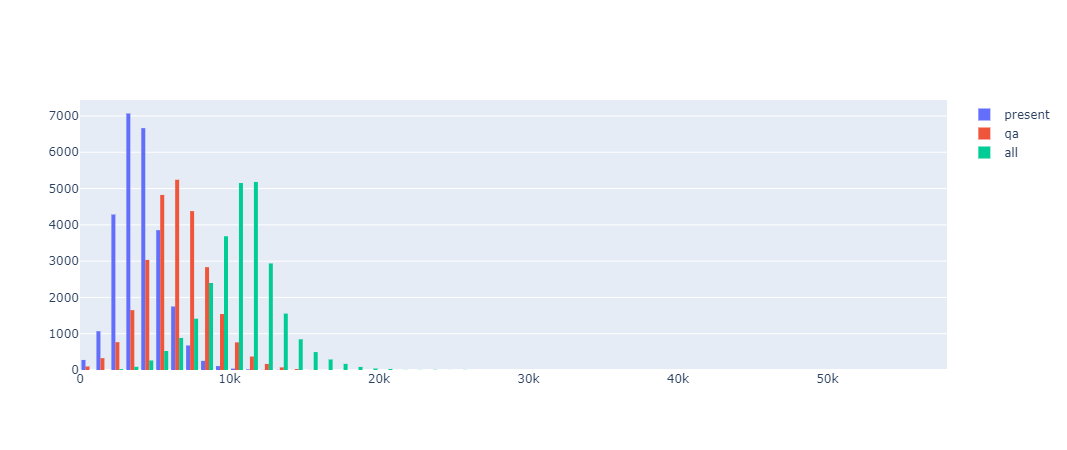

In [50]:
import plotly.express as px
import plotly.graph_objects as go

fig = (go.Figure(go.Histogram(x=seq_len_present, nbinsx=100, name='present'))
    .add_histogram(x=seq_len_qa, name='qa')
    .add_histogram(x=seq_len_all, name='all')
    .update_layout(autosize=False))
fig.write_html('data/seq_len_tokenized_by_XLNet.html', include_plotlyjs='cdn')
fig

In [37]:
batch_size = 2
seq_len = 10000
vocab_size = 32000

with torch.no_grad():
    for i in tqdm(range(5)):
        inputs = torch.tensor(list(torch.utils.data.RandomSampler(range(vocab_size), replacement=True, num_samples=batch_size*seq_len))).reshape(batch_size, seq_len)
        y = xlnet_model(inputs)[0].to(cpu)

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "C:\Software\Anaconda\lib\site-packages\torch\nn\parallel\parallel_apply.py", line 60, in _worker
    output = module(*input, **kwargs)
  File "C:\Software\Anaconda\lib\site-packages\torch\nn\modules\module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "C:\Software\Anaconda\lib\site-packages\transformers\modeling_xlnet.py", line 858, in forward
    head_mask=head_mask[i])
  File "C:\Software\Anaconda\lib\site-packages\torch\nn\modules\module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "C:\Software\Anaconda\lib\site-packages\transformers\modeling_xlnet.py", line 436, in forward
    head_mask=head_mask)
  File "C:\Software\Anaconda\lib\site-packages\torch\nn\modules\module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "C:\Software\Anaconda\lib\site-packages\transformers\modeling_xlnet.py", line 387, in forward
    q_head_h, k_head_h, v_head_h, k_head_r, seg_mat=seg_mat, attn_mask=attn_mask_h, head_mask=head_mask)
  File "C:\Software\Anaconda\lib\site-packages\transformers\modeling_xlnet.py", line 261, in rel_attn_core
    bd = torch.einsum('ibnd,jbnd->bnij', q_head + self.r_r_bias, k_head_r)
  File "C:\Software\Anaconda\lib\site-packages\torch\functional.py", line 241, in einsum
    return torch._C._VariableFunctions.einsum(equation, operands)
RuntimeError: CUDA out of memory. Tried to allocate 8.94 GiB (GPU 0; 11.00 GiB total capacity; 5.17 GiB already allocated; 87.69 MiB free; 9.21 GiB reserved in total by PyTorch)


# Merge embeddings

## merge pre-embedding

In [ ]:
%%time
def merge_preembeddings(preembedding_type, text_type):
    # load text_sentencied, (tid, sid, text)
    # which is used for checking embedding number
    if f'text_{text_type}_sentencized' not in globals():
        text_sentencized = pd.read_feather(f'{DATA_DIR}/text_{text_type}_sentencized.feather')
    
    # load preembeddings
    embedding_paths = [file for file in os.listdir(f'{DATA_DIR}/embeddings') if re.search(f'text_{preembedding_type}', file)]
    for path in embedding_paths: print(path)
        
    print(f'Loading preembeddings...')
    preembeddings_tmp = []
    for embedding_path in tqdm(embedding_paths):
        preembeddings_tmp.extend(torch.load(f'{DATA_DIR}/embeddings/{embedding_path}'))
        
    emb_dim = preembeddings_tmp[0][2].shape[0]
        
    # check if every sentence in `text_sentencized` has been preencoded
    # for every missing sentences, replacing with torch.zeros(1024)
    # The reason that some sentences have not been encoded is that the batch_size is 
    # an even number while the total number of sentences may be odd, in which case
    # the last sentence of the dataset will be removed.
    tid_sid_from_text_sentencized = set(f'{tid}-{sid}' for tid, sid in zip(text_sentencized.transcriptid, text_sentencized.sentenceid))

    tid_sid_from_preembeddings = set(f'{tid}-{sid}' for tid, sid, _ in preembeddings_tmp)

    for tid_sid in tid_sid_from_text_sentencized:
        if tid_sid not in tid_sid_from_preembeddings:
            tid, sid = tid_sid.split('-')
            tid = int(tid)
            sid = int(sid)
            text = text_sentencized.loc[(text_sentencized.transcriptid==tid) & (text_sentencized.sentenceid==sid)]['text'].values[0]
            print('Not found:')
            print(f'  trascriptid: {tid}  sentenceid: {sid}')
            print(f'  text: {text}')
            print(f'-----------')

            preembeddings_tmp.append((tid, sid, np.zeros(emb_dim)))
            
    assert len(preembeddings_tmp)==len(text_sentencized), 'preembedding # != sentence #'
        
    # sort by (transcriptid, sentenceid)
    print(f'sorting by (transcriptid, sentenceid)')
    preembeddings_tmp.sort(key=itemgetter(0,1))
    
    # group by transcriptid
    preembeddings_bytid = defaultdict(list)
    for transcriptid, _, emb in preembeddings_tmp:
        preembeddings_bytid[transcriptid].append(emb)

    preembeddings_bytid_stacked = {}
    print('Stacking embeddings...')
    for k, v in tqdm(preembeddings_bytid.items()):
        preembeddings_bytid_stacked[k] = torch.tensor(np.array(v))
    print(f'N call event: {len(preembeddings_bytid_stacked)}')

    return preembeddings_bytid_stacked



for text_type in ['all']:
    # merge preembeddings
    preembedding_type = f'{text_type}_sbert_roberta_nlistsb_encoded'
    preembedding_name = f'preembeddings_{preembedding_type}'
    preembeddings = merge_preembeddings(preembedding_type, text_type)
    # save preembeddings
    print(f'saving preembeddings...')
    torch.save(preembeddings, f'{DATA_DIR}/embeddings/{preembedding_name}.pt')

Save valid preembeddings keys
> I found some `transcriptid`s in `targets_df` are NOT in `preembeddings`. So I save all valid preembeddings keys and use that to filter out invalid obervations `targets_df` 

In [15]:
# helpers: load preembeddings
def load_preembeddings(preembedding_type):
    if 'preembeddings' not in globals():
        print(f'Loading preembeddings...@{Now()}')
        globals()['preembeddings'] = torch.load(f"{DATA_DIR}/embeddings/preembeddings_{preembedding_type}.pt")
        print(f'Loading finished. @{Now()}')
        
load_preembeddings('all_sbert_roberta_nlistsb_encoded')

valid_preembedding_keys_all = pd.DataFrame({'valid_keys_all':list(set(preembeddings.keys()))})
feather.write_feather(valid_preembedding_keys_all, 'data/valid_preembedding_keys_all.feather', compression='uncompressed')

## check `id-text` pair 

> Task: final check that id-text are correctly matched
>
> Check **Pass!**

In [ ]:
cpu_model = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

In [16]:
text_sentencized = pd.read_feather(f'{DATA_DIR}/text_all_sentencized.feather')
targets_df = pd.read_feather(f'{DATA_DIR}/f_sue_keydevid_car_finratio_transcriptid_text.feather')

In [33]:
preembeddings[1441428][123]

tensor([0.5312, 1.3299, 0.4254,  ..., 0.1801, 0.9385, 0.5650])

In [34]:
text = text_sentencized[(text_sentencized.transcriptid==1441428) & (text_sentencized.sentenceid==123)]
text = text['text'].tolist()

cpu_model.encode(text)

[array([0.531192  , 1.3299239 , 0.42536   , ..., 0.18007116, 0.9384972 ,
        0.56497455], dtype=float32)]

In [52]:
class CCDataset(Dataset):
    
    def __init__(self, preembeddings: list, targets_df, split_window, split_type, transcriptids=None, transform=None):
        '''
        Args:
            preembeddings: list of embeddings. Each element is a tensor (S, E) where S is number of sentences in a call
            targets_df: DataFrame of targets variables.
            split_window: str. e.g., "roll-09"
            split_type: str. 'train' or 'test'
            transcriptids: list. If provided, only the given transcripts will be used in generating the Dataset. `transcriptids` is applied **on top of** `split_window` and `split_type`
        '''

        # get split dates from `split_df`
        _, train_start, train_end, test_start, test_end = tuple(split_df.loc[split_df.window==split_window].iloc[0])
        train_start = datetime.strptime(train_start, '%Y-%m-%d').date()
        train_end = datetime.strptime(train_end, '%Y-%m-%d').date()
        test_start = datetime.strptime(test_start, '%Y-%m-%d').date()
        test_end = datetime.strptime(test_end, '%Y-%m-%d').date()
        
        # select valid transcriptids (preemb_keys) according to split dates 
        if split_type=='train':
            transcriptids = targets_df[targets_df.ciq_call_date.between(train_start, train_end)].transcriptid.tolist()
        elif split_type=='test':
            transcriptids = targets_df[targets_df.ciq_call_date.between(test_start, test_end)].transcriptid.tolist()

        self.valid_preemb_keys = set(transcriptids).intersection(set(preembeddings.keys()))
        
        if transcriptids is not None:
            self.valid_preemb_keys = self.valid_preemb_keys.intersection(set(transcriptids))
        
        # self attributes
        self.targets_df = targets_df
        self.preembeddings = preembeddings
        self.transform = transform
        self.sent_len = sorted([(k, preembeddings[k].shape[0]) 
            for k in self.valid_preemb_keys],
            key=itemgetter(1))
        self.train_start = train_start
        self.train_end = train_end
        self.test_start = test_start
        self.test_end = test_end
        self.n_samples = len(self.sent_len)
        self.split_window = split_window
        self.split_type = split_type
        
    def __len__(self):
        return (len(self.valid_preemb_keys))
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        transcriptid = self.sent_len[idx][0]
        targets = self.targets_df[self.targets_df.transcriptid==transcriptid].iloc[0]
        
        # inputs: preembeddings
        embeddings = self.preembeddings[transcriptid]
        
        # all of the following targests are
        # of type `numpy.float64`
        mcap = targets.mcap
        sue = targets.sue
        suelag = targets.sue_lag1
        selag = targets.se_lag1
        se = targets.se
        selead = targets.se_lead1
        sestlag = targets.sest_lag1
        sest = targets.sest
        car_0_30 = targets.car_0_30
        car_0_30_lag = targets.car_0_30_lag1
        
        return transcriptid, embeddings, mcap, suelag, sue, car_0_30_lag, car_0_30, se, selead, sestlag, sest


# # test DataSet...
# targets_df_path = f'{DATA_DIR}/f_sue_keydevid_car_finratio_transcriptid_text.feather'
# preembedding_type = 'ques_sbert_roberta_nlistsb_encoded'

# # load preembeddings
# if 'preembeddings' not in globals():
#     print(f'Loading preembeddings...{Now()}')
#     preembeddings = torch.load(f'{DATA_DIR}/embeddings/preembeddings_{preembedding_type}.pt')
#     print(f'Loading finished. {Now()}')
    
# # load targets_df
# if 'targets_df' not in globals():
#     targets_df = pd.read_feather(targets_df_path)

# # choose train/val split
# split_df = pd.read_csv(f'{DATA_DIR}/split_dates.csv')

# # create Dataset
# test_ds = CCDataset(preembeddings, targets_df, split_window='roll-19', split_type='train')

# test_ds[876]

# Backup

In [15]:
# load (X,Y)
%time targets_df = pd.read_feather(f'{DATA_DIR}/f_sue_keydevid_car_finratio_vol_transcriptid_sim_inflow_revision_retail_sentiment_text.feather')
print(f'num of calls: {len(targets_df)}')

targets_df.iloc[0:1]

Wall time: 2.59 s
num of calls: 21763


,gvkey,ciq_release_date,docid,ciq_call_date,fyear,fqtr,release_keydevid,call_keydevid,transcriptid,ret_0_10,...,retail_net_m10_0,retail_net_m3_0,retail_net_0_3,retail_net_0_10,retail_net_0_30,text_present,text_qa,text_ques,text_ans,text_all
0,001013,2008-03-05,001013-2008-03-05,2008-03-05,2008.0,1.0,5241424,5152678,320,-12.370371,...,0.0,0.0,0.0,0.0,0.0,Good afternoon and thank you for joining us on...,My question is regarding your organic sales gr...,My question is regarding your organic sales gr...,I think if you go back and you actually exclud...,Good afternoon and thank you for joining us on...


In [2]:
model_path = "C:/Users/rossz/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_roberta-large-nli-stsb-mean-tokens.zip"

with open(os.path.join(model_path, 'modules.json')) as fIn:
    contained_modules = json.load(fIn)

sbert_modules = OrderedDict()
for module_config in contained_modules:
    module_class = sentence_transformers.util.import_from_string(module_config['type'])
    module = module_class.load(os.path.join(model_path, module_config['path']))
    sbert_modules[module_config['name']] = module

# For Roberta, pad_token_id == 1
if 'roberta' in model_path:
    sbert_pad_token_id = 1
else:
    raise Exception("You're not using RoBERTa, double check your pad_token_id")


sbert_model = nn.Sequential(sbert_modules)
log_gpu_memory()

GPU 0:  0.00/ 11.00 (GB)
GPU 1:  0.00/ 11.00 (GB)
